In [2]:
import torch, torch.nn as nn

In [5]:
from Models.sequential import Sequential_Model
from Layers.linear import Linear_Layer
from Activations.relu import relu
from Activations.sigmoid import sigmoid
from Loss_Func.log_loss import log_loss
from Metrics.acc import accuracy

In [12]:
#Model Architecture

d_in = 10
d_h = 4
d_o = 1

In [13]:
#Random Data
x_rand = torch.normal(0,1,(d_in,100))
y_rand = torch.sum(x_rand, dim=0)
y_rand = (y_rand>0).to(x_rand.dtype)

In [14]:
model = Sequential_Model([Linear_Layer(d_in,d_h),
                          relu(),
                          Linear_Layer(d_h,d_o),
                          sigmoid()], log_loss)

In [15]:
epochs = 1000
loss_history = []
acc_history = []

for i in range(epochs):
    preds = model.forward_pass(x_rand)
    #print(preds, y_rand)
    loss = model.loss_calc(y_rand, preds)
    model.backward_pass()
    model.step(1e-3)
    
    loss_history.append(loss)
    acc_history.append(accuracy(y_rand, preds))

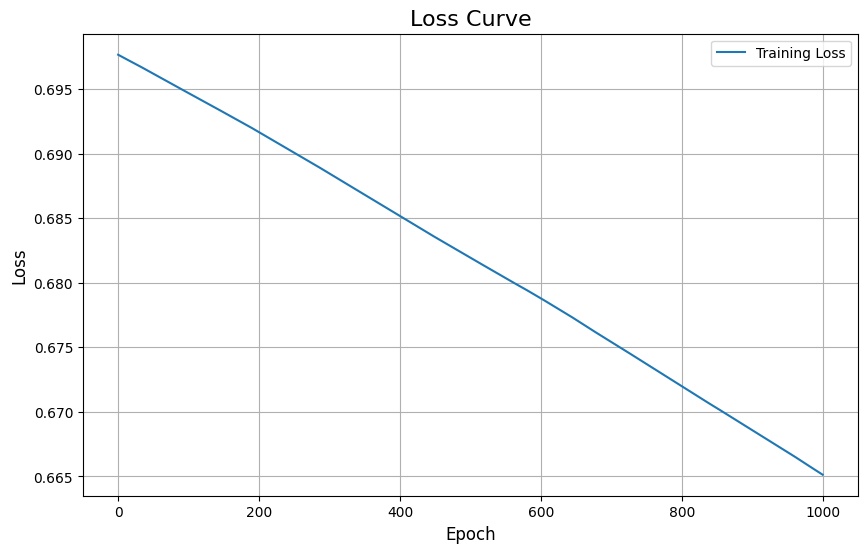

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(epochs), loss_history, label='Training Loss')
plt.title('Loss Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)

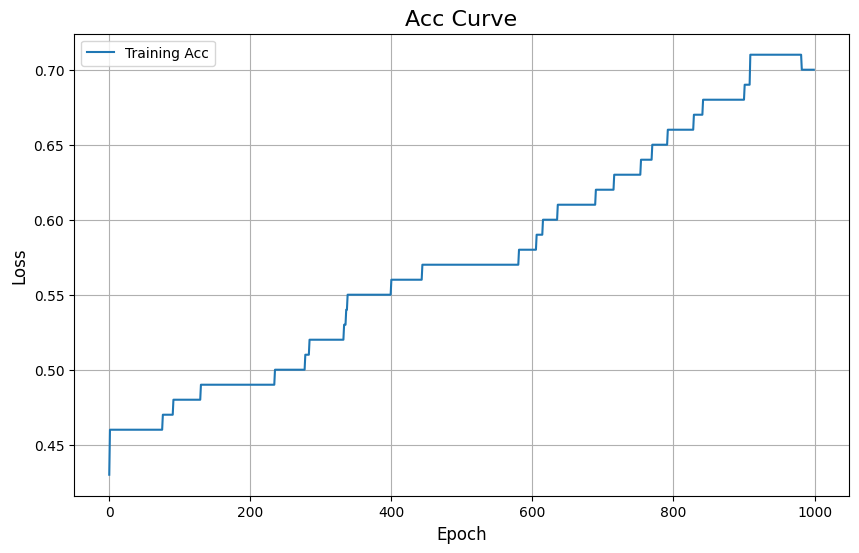

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(np.arange(epochs), acc_history, label='Training Acc')
plt.title('Acc Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)